# Getting started

Once you've chosen your scenario, download the data from [the Iowa website](https://data.iowa.gov/Economy/Iowa-Liquor-Sales/m3tr-qhgy) in csv format. Start by loading the data with pandas. You may need to parse the date columns appropriately.

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn import datasets
from sklearn import linear_model
import os

from sklearn.cross_validation import train_test_split
from sklearn.cross_validation import cross_val_score
from sklearn.cross_validation import cross_val_predict

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import matplotlib.pyplot as plt
%matplotlib inline


# iowa_data = pd.read_csv('/Users/HudsonCavanagh/Documents/Iowa_Liquor_Sales.csv') -- this is where need to update with full dataset (eventually)
iowa_data = pd.read_csv('/Users/HudsonCavanagh/Documents/Iowa_Liquor_sales_sample_10pct.csv')
ia = pd.DataFrame(iowa_data) 
ia.dropna(how='any', axis=0, inplace=True)
ia['Date'] = pd.to_datetime(ia['Date'], infer_datetime_format=True)

iowa_zip_data = pd.read_csv('/Users/HudsonCavanagh/dsi-projects/projects/3rd - IA Liquor/iowa_zip_pop.csv')
ia_zip_pop = pd.DataFrame(iowa_zip_data) 
ia_zip_pop.dropna(how='any', axis=0, inplace=True)


# works = []
# issues = []
    
# for val in g.index:
#     if '-' in val:
#         issues.append(val)
#     elif str(int(val)) == val:
#         works.append(val)
#     else:
#         issues.append(val)

In [2]:
#clean IA ZIP POP HERE

# ia_zip_pop = ia_zip_pop.loc['Reportdata link 1', 'Reportdata number 2', 'Reportdata link 2', 'Reportdata number 4']
##ORIGINAL VERSION:
# ia_zip_pop = ia_zip_pop.iloc[:,(2,4,5,8)]
# column_iazip = ['zip', 'lat_long', 'city', 'pop_dense_heads_sqm']

#REVISED FOR MERGING


ia_zip_pop = ia_zip_pop.iloc[:,(2,10)]
column_iazip = ['zip', 'pop_dense_heads_sqm']
ia_zip_pop.columns = column_iazip
# ia_zip_pop.dropna(inplace=True)
ia_zip_pop['zip'] = ia_zip_pop['zip'].apply(lambda x: str(x))
ia_zip_pop['pop_dense_heads_sqm'] = ia_zip_pop['pop_dense_heads_sqm'].apply(lambda x: float(x)) 
#could not get the above to read commas in numbers over 1k with float or int, did conversion in google sheets

In [3]:
#rename columns in main dataframe

ia.rename(columns={'Date': 'date', 'Store Number': 'store_num', 'City': 'city', 'Zip Code': 'zip', 'County Number': 'county_num', 'County': 'county_name', 'Category': 'cat', 'Category Name': 'cat_name'}, inplace=True)
ia.rename(columns={'Vendor Number': 'vend_id', 'Item Number': 'item_id', 'Item Description': 'item', 'Bottle Volume (ml)': 'vol_per_bottle_ml', 'State Bottle Cost': 'bottle_cost', 'State Bottle Retail': 'retail_unit_rev', 'Bottles Sold': 'bottles_sold'}, inplace=True)
ia.rename(columns={'Sale (Dollars)': 'trans_revenue', 'Volume Sold (Liters)': 'vol_sold_liters'}, inplace=True)
ia = ia.iloc[:,0:17]

len(ia['store_num'])

269258

In [4]:
#CONVERT DATATYPES, prepare g with index zip

# ia['date'].value_counts  #dtype time 64
# ia['store_num'].value_counts  #int, should be string
ia['store_num'] = ia['store_num'].apply(lambda x: str(x))
# ia['city'].value_counts #object, ok
# ia['zip'].value_counts #object, ok
# ia['county_num'].value_counts #float, should be object
ia['county_num'] = ia['county_num'].apply(lambda x: str(x))
# ia['county_name'].value_counts #object, ok
# ia['cat'].value_counts #int, should be obj
                                          
ia['cat'] = ia['cat'].apply(lambda x: str(x))
                                          
                                 
# ia['cat_name'].value_counts #str
ia['vend_id'] = ia['vend_id'].apply(lambda x: str(x))
ia['item_id'] = ia['item_id'].apply(lambda x: str(x))
# ia['item'].value_counts #str
ia['liters_per_bottle'] = (ia['vol_per_bottle_ml'].apply(lambda x: float(x)/1000))
ia['bottles_sold'] = (ia['bottles_sold'].apply(lambda x: float(x)))

##THIS DATA CLEAN, JUST NEED TO CONVERT DOLLAR COLUMNS

ia['bottle_cost'] = ia['bottle_cost'].apply(lambda x: x.strip('$'))
ia['bottle_cost'] = ia['bottle_cost'].apply(lambda x: float(x))

ia['retail_unit_rev'] = ia['retail_unit_rev'].apply(lambda x: x.strip('$'))
ia['retail_unit_rev'] = ia['retail_unit_rev'].apply(lambda x: float(x))

ia['trans_revenue'] = ia['trans_revenue'].apply(lambda x: x.strip('$'))
ia['trans_revenue'] = ia['trans_revenue'].apply(lambda x: float(x))


gg = ia.set_index('zip')
ia_zipindex_pop = ia_zip_pop.set_index('zip')

g = pd.merge(gg, ia_zipindex_pop, how='left', sort=False, left_index=True, right_index=True)#returns duplicate indices with meaningful data
g = g.dropna(axis=0, how='any')


# g = g.groupby(g.index).mean() #this needs to occur after split by dates b/c it drops dates




In [5]:
g.head()

,date,store_num,city,county_num,county_name,cat,cat_name,vend_id,item_id,item,vol_per_bottle_ml,bottle_cost,retail_unit_rev,bottles_sold,trans_revenue,vol_sold_liters,liters_per_bottle,pop_dense_heads_sqm
zip,,,,,,,,,,,,,,,,,,
50002,2015-07-06,4417,ADAIR,1.0,Adair,1031080.0,VODKA 80 PROOF,260,38008,Smirnoff Vodka 80 Prf Pet,1750,14.75,22.13,6,132.78,10.5,1.750,12
50002,2015-01-26,4753,ADAIR,1.0,Adair,1031080.0,VODKA 80 PROOF,300,36904,Mccormick Vodka Pet,375,1.80,2.70,24,64.80,9.0,0.375,12
50002,2015-03-23,4417,ADAIR,1.0,Adair,1012100.0,CANADIAN WHISKIES,115,11776,Black Velvet,750,5.23,7.85,12,94.20,9.0,0.750,12
50002,2015-05-18,4417,ADAIR,1.0,Adair,1031080.0,VODKA 80 PROOF,260,37994,Smirnoff Vodka 80 Prf,375,4.75,7.13,24,171.12,9.0,0.375,12
50002,2015-01-26,4753,ADAIR,1.0,Adair,1062310.0,SPICED RUM,260,43334,Captain Morgan Spiced Rum,375,5.00,7.50,24,180.00,9.0,0.375,12


In [5]:
#WORKING SPLITTING CELL



g['year'] = g.date.dt.year
g['quarters'] = g.date.dt.quarter


g_2015 = g[g.year == 2015]
q1 = g_2015[g_2015.quarters == 1]
q2 = g_2015[g_2015.quarters == 2]
q3 = g_2015[g_2015.quarters == 3]
q4 = g_2015[g_2015.quarters == 4]
q234 = g_2015[g_2015.quarters == [2 or 3 or 4]]
q5 = g[g.year == 2016]


q1_X = q1.drop('trans_revenue', 1)
q1_X['constant'] = 1



#COULD ADD BACK CAT, VEND categoricals

q1_X = q1_X.groupby(q1_X.index).mean()
q1_X['avg_trans_size'] = q1_X['retail_unit_rev']
q1_X['avg_vol_sold_L'] = q1_X['vol_sold_liters']
q1_X['avg_bottles_sold'] = q1_X['bottles_sold'] #NOT using this in model (removed below) b/c same as above
q1_X['avg_profit'] = q1_X['avg_trans_size'] - q1_X['bottle_cost']
q1_X['avg_vol_per_bottle_sold_L'] = q1_X['vol_per_bottle_ml']/1000


In [6]:
q1_X.head()

,vol_per_bottle_ml,bottle_cost,retail_unit_rev,bottles_sold,vol_sold_liters,liters_per_bottle,pop_dense_heads_sqm,year,quarters,constant,avg_trans_size,avg_vol_sold_L,avg_bottles_sold,avg_profit
zip,,,,,,,,,,,,,,
50002,493.181818,4.748182,7.123636,20.545455,8.509091,0.493182,12,2015,1,1,7.123636,8.509091,20.545455,2.375455
50003,864.333333,7.870933,11.811867,12.026667,11.067600,0.864333,50,2015,1,1,11.811867,11.067600,12.026667,3.940933
50006,1144.230769,11.144231,16.751923,5.692308,6.773846,1.144231,16,2015,1,1,16.751923,6.773846,5.692308,5.607692
50009,882.113821,9.357940,14.054959,8.970190,8.092846,0.882114,407,2015,1,1,14.054959,8.092846,8.970190,4.697019
50014,971.698113,11.619906,17.445094,8.330189,8.003585,0.971698,580,2015,1,1,17.445094,8.003585,8.330189,5.825189


In [6]:
q1_X = q1_X[['avg_trans_size','avg_vol_sold_L','avg_profit','pop_dense_heads_sqm','avg_vol_per_bottle_sold_L', 'constant']]



q234_y = q234['trans_revenue']   

q234_Y = pd.DataFrame(q234_y)
q234_Y = q234_Y.groupby(q234_Y.index).mean()

# q1_X_trim = pd.merge(q1_X, q234_Y, how='left', left_index=1, right_index=1)

q234_Y.head()

,trans_revenue
zip,
50002,130.457143
50003,117.737500
50006,110.122647
50009,135.874933
50014,109.768118


In [7]:
# print(len(q1_X), len(q234_Y)) #shows that q1_X has (357 indices, compared to 360 for y)
#THIS FUNCTION CHECKS WHAT IS IN CONFLICT; OPPOSITE VERSION BELOW
# x_list = []
# y_list = []
# conflict = []

# for i in q234_Y.index:
#     y_list.append(i)
    
# for j in q1_X.index:
#     x_list.append(j)
    
# for h in y_list:
#     if h not in x_list:
#         conflict.append(h)

# print(conflict)


#['50061', '50135', '51038', '52347'] -- conflicting zips with y val, no x val



In [7]:
x_list = []
y_list = []
conflict = []

for i in q234_Y.index:
    y_list.append(i)
    
for j in q1_X.index:
    x_list.append(j)
    
for h in x_list:
    if h not in y_list:
        conflict.append(h)

print(conflict)
#['51535']

['51535']


In [8]:
# q1_X.loc['50061'] #error
# q234_Y.loc['50061'] #drop
# q234_Y.loc['50135'] #drop
# q234_Y.loc['51038'] #drop
# q234_Y.loc['52347'] #drop
# q234_Y = q234_Y.drop(q234_Y[['50061', '50135', '51038', '52347']]) #couldn't get this to work, dropping individuals


q234_Y = q234_Y.drop('50061')
q234_Y = q234_Y.drop('50135')
q234_Y = q234_Y.drop('51038')
q234_Y = q234_Y.drop('52347')
q1_X = q1_X.drop('51535')


In [9]:
X_train, X_test, y_train, y_test = train_test_split(q1_X, q234_Y, test_size=.33)
# X_train, X_test, y_train, y_test = train_test_split(q1_X_trim, q234_Y, test_size=.33) #with trim


print "       X Shape  Y Shape"
print "Train", X_train.shape, y_train.shape
print "Test ", X_test.shape, y_test.shape


       X Shape  Y Shape
Train (238, 6) (238, 1)
Test  (118, 6) (118, 1)


In [10]:
print(len(q1_X), len(q234_Y))

(356, 356)


# Explore the data

Perform some exploratory statistical analysis and make some plots, such as histograms of transaction totals, bottles sold, etc.

## Record your findings

Be sure to write out anything observations from your exploratory analysis.

# Mine the data
Now you are ready to compute the variables you will use for your regression from the data. For example, you may want to
compute total sales per store from Jan to March of 2015, mean price per bottle, etc. Refer to the readme for more ideas appropriate to your scenario.

Pandas is your friend for this task. Take a look at the operations [here](http://pandas.pydata.org/pandas-docs/stable/groupby.html) for ideas on how to make the best use of pandas and feel free to search for blog and Stack Overflow posts to help you group data by certain variables and compute sums, means, etc. You may find it useful to create a new data frame to house this summary data.

# Refine the data
Look for any statistical relationships, correlations, or other relevant properties of the dataset.

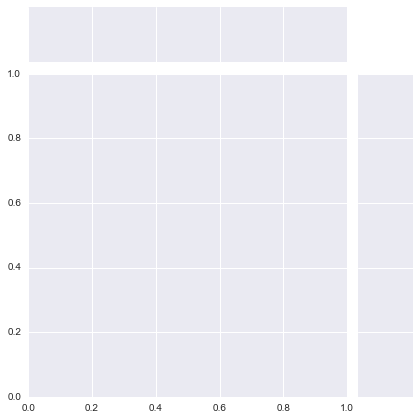

In [14]:
# MAKE TONS OF PLOTS, seaborn
import seaborn as sns

# sns.JointGrid("pop_dense", "vol_sold_L", data=q1)
# sns.JointGrid("pop_dense", "profit", data=q1)
# sns.JointGrid("pop_dense", "profit_margin", data=q1)
# sns.JointGrid("pop_dense", "vol_sold_L", data=q1)


#can do some more using this data:
# q1 q234

# Build your models

Using scikit-learn or statsmodels, build the necessary models for your scenario. Evaluate model fit.

Score: 0.330612216682


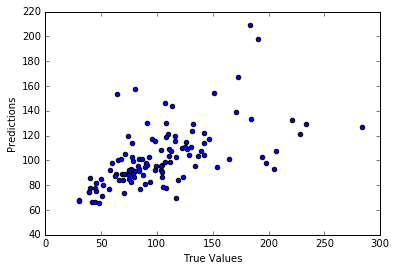

In [11]:
rcv = linear_model.RidgeCV(alphas=
                           (.001, .001, .01, .1, .5, 1, 5, 10),
                           store_cv_values=True)
rcv_model = rcv.fit(X_train, y_train)
y_predicted = rcv_model.predict(X_test)
rcv_r2 =  r2_score(y_true=y_test, y_pred=y_predicted)
rcv_r2

plt.scatter(y_test, y_predicted) #compare the hold-out observed y values to the predictions (made with model from test data)
plt.xlabel("True Values")
plt.ylabel("Predictions")

print "Score:", rcv_model.score(X_test, y_test)



In [12]:
rcv_model.cv_values_.mean()

a_rcv = rcv_model.alpha_ #this returns optimal alpha for dataset

print(cross_val_score(rcv_model, q1_X, q234_Y, n_jobs=1, cv=5), 
"mean:", cross_val_score(rcv_model, q1_X, q234_Y, n_jobs=1, cv=5).mean()) #multiple jobs


(array([ 0.21496673,  0.23490464,  0.27356415,  0.20041132,  0.51667084]), 'mean:', 0.28810353688593626)


In [ ]:
# from sklearn import linear_model


# lm = linear_model.LinearRegression()

# X = 
# y = 

# model = lm.fit(X, y)
# predictions = lm.predict(X)


In [ ]:
# # How is it performing? Plot the model's predictions against actual values
# # s = s: size in points, c = color, zorder = layer order

# plt.figure(figsize=(16,8))
# plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
# plt.xlabel("Predicted Values")
# plt.ylabel("Actual Values")
# plt.show()
# print "MSE:", mean_squared_error(y, predictions)

# 

In [ ]:
cross_val_score(lr, X, y, n_jobs=1, cv=5).mean() #multiple jobs

In [ ]:
#plot the residuals

plt.figure(figsize=(16,8))
plt.scatter(y, y - predictions, c = 'b', marker = '+') # Look directly at the residuals
plt.axhline(0, color='r') #from http://localhost:8888/notebooks/week03/W3%20L1.3_scikit-modeling.ipynb

In [ ]:
#OLS

# Note the difference in argument order
OLSmodel = sm.OLS(y, X).fit()
predictions = model.predict(X)

# Plot the model
plt.scatter(predictions, y, s=30, c='r', marker='+', zorder=10)
plt.xlabel("Predicted Values")
plt.ylabel("Actual Values")
plt.show()
print "MSE:", mean_squared_error(y, predictions)

cross_val_score(lr, X, y, n_jobs=1, cv=5).mean() #multiple jobs


In [ ]:
print(OLSmodel.summary())

In [ ]:
#standardized Ridge Model



Score: 0.129447762604
(7.38140372119544, array([ 0.        ,  5.98582104,  0.        ,  0.01733129,  0.        ]))


/Users/HudsonCavanagh/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


AttributeError: 'DataFrame' object has no attribute 'predict'

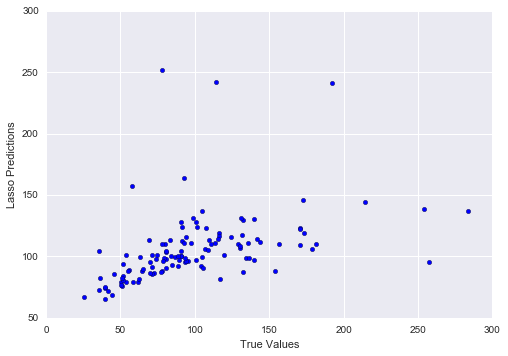

In [21]:
#standardized lasso model

lcv = linear_model.LassoCV()
lcv_model = lcv.fit(X_train, y_train)
y_lasso_predicted = lcv_model.predict(X_test)
lcv_r2 =  r2_score(y_true=y_test, y_pred=y_predicted)
lcv_r2

plt.scatter(y_test, y_lasso_predicted) #compare the hold-out observed y values to the predictions (made with model from test data)
plt.xlabel("True Values")
plt.ylabel("Lasso Predictions")

print "Score:", lcv_model.score(X_test, y_test)

print(lcv_model.alpha_, #this returns optimal alpha for dataset
abs(lcv_model.coef_))

# final_predicts = ia.predict(modelname, X)

In [ ]:
#iterate through r2 or mse a bunch

for i in range(1000):
    cross_val_list = []
    n = cross_val_score(lasso, X, y, n_jobs=1, cv=5, scoring='r2').mean()
    cross_val_list.append(n)
print(np.mean(cross_val_list))


# cross_val_score(lr, X, y, n_jobs=1, cv=5,
#                 scoring='mean_squared_error').mean()

In [22]:
# sample code for cross_validated output


X_train, X_test, y_train, y_test = train_test_split(q1_X, q234_Y, test_size=.4)

lcv_model = lcv.fit(X_train, y_train)
lcv_pred = lcv.predict(X_test)
lasso_r2 =  r2_score(y_true=y_test, y_pred=lcv_pred)
print("R sq for Lasso Reg is:", lasso_r2)

print("cross validated r^2:", np.mean(cross_val_score(lcv_model, X_test, y_test, scoring='r2', cv=5)))
print("r^2 w/o cross-validation", (lcv_model.score(X_test,y_test)))
print("cross validated MSE (sign flipped):", -np.mean(cross_val_score(lcv_model, X_test, y_test, scoring='mean_squared_error', cv=5)))
print("MSE w/o cross-validation", (lcv_model.score(X_test,y_test)))

# mse
# bar
# bias

/Users/HudsonCavanagh/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/HudsonCavanagh/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/HudsonCavanagh/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/HudsonCavanagh/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: D

('R sq for Lasso Reg is:', 0.26385748680956544)
('cross validated r^2:', 0.16049592505725241)

/Users/HudsonCavanagh/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/HudsonCavanagh/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/HudsonCavanagh/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/HudsonCavanagh/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: D


('r^2 w/o cross-validation', 0.26385748680956544)
('cross validated MSE (sign flipped):', 1628.1155526679199)
('MSE w/o cross-validation', 0.26385748680956544)


/Users/HudsonCavanagh/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/HudsonCavanagh/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/HudsonCavanagh/anaconda/lib/python2.7/site-packages/sklearn/linear_model/coordinate_descent.py:1051: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [23]:
###LOSS FUNCTIONS

from sklearn.metrics import mean_squared_error, mean_absolute_error
print "RMSE:", mean_squared_error(ys, predictions)
print "MAE:", mean_absolute_error(ys, predictions)

RMSE:

NameError: name 'ys' is not defined

In [ ]:
#QUANT REG

df = pd.DataFrame(np.array([xs, ys]).transpose(), columns=["x", "y"])
df.columns = ["x", "y"]
mod = smf.quantreg('y ~ x', df)
res = mod.fit(q=.5)
print(res.summary())




In [ ]:
#HELPFUL FUNCTIONS

# Gradient Descent/ Optimizing Functions:
    
    
def mean_squared_error(y_true, x, beta0, beta1):
    y_pred = beta0 + x * beta1
    mean_sq_err = np.mean((y_true - y_pred)**2)
    return mean_sq_err

def gradient_update(y, x, beta0, beta1, step_size):
    
    beta0_gradient = 0
    beta1_gradient = 0
    
    N = float(len(y))
    
    for i in range(len(y)):
        
        # add to the beta0 gradient for each x,y using the partial derivative with respect to beta0
        beta0_gradient += (2./N * -1 * (y[i] - (beta0 + beta1*x[i])))
        
        # add to the beta1 gradient for each x,y using the partial derivative with respect to beta1
        beta1_gradient += (2./N * -1 * x[i] * (y[i] - (beta0 + beta1*x[i])))
        
    # update beta0 and beta1:
    beta0 = beta0 - (step_size * beta0_gradient) #subtracting because we want to move in the opposite direction of the gradient
    #this is because we want to minimize function
    beta1 = beta1 - (step_size * beta1_gradient)
    
    return [beta0, beta1]



def gradient_descent_iterator(y, x, beta0, beta1, step_size=.0001, iterations=500):
    
    mean_squared_errors = []
    mean_squared_errors.append(mean_squared_error(y, x, beta0, beta1))
    
    beta0s = [beta0]
    beta1s = [beta1]
    
    for i in range(iterations):
        [beta0, beta1] = gradient_update(y, x, beta0, beta1, step_size)
        mean_squared_errors.append(mean_squared_error(y, x, beta0, beta1))
        beta0s.append(beta0)
        beta1s.append(beta1)
        
    return [mean_squared_errors, beta0s, beta1s]



# format for runnning the above 3 functions:
    
x = np.random.random_sample(100)*100
y = x + np.random.normal(np.random.normal(0,15), 30, size=100) + 100

plt.figure(figsize=(10,8))

plt.scatter(x, y, s=70, c='steelblue')

plt.show()



### Plotting functions from earlier (nonessential)



def plot_regression(x, y, model):
    plt.figure(figsize=(10,8))
    axes = plt.gca()
    
    intercept = model.params[0]
    slope = model.params[1]

    for x_, y_ in zip(x, y):    
        plt.plot((x_, x_), (y_, x_*slope + intercept),
                 'k-', ls='dashed', lw=1)
        
    plt.scatter(x, y, s=70, c='steelblue')
    
    x_points = np.linspace(axes.get_xlim()[0], axes.get_xlim()[1], 100)
    
    regline_x = x_points
    regline_y = x_points*slope + intercept

    plt.plot(regline_x, regline_y, c='darkred', lw=3.5)

    plt.show()
    
    
def plot_leastsq_loss(model):
    plt.figure(figsize=(10,8))
    
    resids = model.resid
    
    resid_lim = np.max([abs(np.min(resids)), abs(np.max(resids))]) + 1
    
    resid_points = np.linspace(-1*resid_lim, resid_lim, 200)
    
    for r in resids:
        plt.plot((r, r), (0, r**2), 'k-', ls='dashed', lw=2)
        
    plt.plot(resid_points, resid_points**2, c='gold', alpha=0.7)
    

def plot_residuals_ladloss(model):
    
    resids = model.resid
    
    resid_lim = np.max([abs(np.min(resids)), abs(np.max(resids))]) + 1
    
    resid_points = np.linspace(-1*resid_lim, resid_lim, 200)
    
    plt.figure(figsize=(10,8))
    
    for r in resids:
        
        plt.plot((r, r), (0, abs(r)), 'k-', ls='dashed', lw=1)
        
    plt.plot(resid_points, np.abs(resid_points), c='gold', alpha=0.7)
    
    
    
    
    
##REMINDER OF NEXT STEPS:
#from http://localhost:8888/notebooks/week03/loss-functions-regression-metrics-practice.ipynb
# 4: Choose a continuous response variable and predictor variable from the dataset
# 5: Choose a small subset of the predictor and response variables you chose
# 6. Build a least squares regression model predicting your response from your predictors
# plot_regression(x, y, model)
# 7. Plot the least squares regression
# 8. Build a least absolute deviation quantreg model on the same sample
# Plot the LAD regression

# 10. Calculate the RMSE and the MAE between you response and predicted response



In [ ]:
# FUll run-through of gradient descent iteration (redundant with some code above):
    
def func(x):    #this needs to be modified to whatever the specific function is
    if x <= 1:
        return 2 * x * x
    return 2

def gradient(x): #this needs to be the derivative of the func
    if x <= 1:
        return 4 * x
    return 0

def gradient_descent(x, l=0.1):
    vector = np.array(x)
    return vector - l * np.array(gradient(x))


def iterate(x0, n=10):
    xs = [x0]
    ys = [func(x0)]
    for i in range(n):
        x = gradient_descent(xs[-1], l=0.1)
        xs.append(x)
        ys.append(func(x))
    return xs, ys    


xs = np.arange(-2, 3, 0.1)
ys = map(func, xs)

plt.figure(figsize=(10,8))
plt.plot(xs, ys, alpha=0.5, ls='dashed')

# Start gradient descent at x = -1.5
xs2, ys2 = iterate(-1.5, n=100)
plt.scatter(xs2, ys2, c='r', s=100)

# Start gradient descent at x = 2; where does it go?
xs2, ys2 = iterate(2, n=100)
plt.scatter(xs2, ys2, c='y', s=300)

## Plot your results

Again make sure that you record any valuable information. For example, in the tax scenario, did you find the sales from the first three months of the year to be a good predictor of the total sales for the year? Plot the predictions versus the true values and discuss the successes and limitations of your models

In [ ]:
# Plot the data and the best fit line
## The data
plt.scatter(X, y)
## The line / model
plt.plot(X, predictions)

plt.show()
print "r^2:", model.score(X, y)
print "RMSE:", mean_squared_error(ys, predictions)
print "MAE:", mean_absolute_error(ys, predictions)
print "Coefficients:", model.coef_, model.intercept_

# Present the Results

Present your conclusions and results. If you have more than one interesting model feel free to include more than one along with a discussion. Use your work in this notebook to prepare your write-up.